In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.7 MB/s eta 0:00:00


In [ ]:
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from torch_geometric.data import HeteroData, download_url, extract_zip
from keras.layers import Dropout, Flatten, Activation, Input, Embedding, BatchNormalization, Dense, dot
from keras.optimizers import Adam
from pylab import rcParams
from tqdm.notebook import tqdm
import os
import pandas as pd
import numpy as np
import keras
import torch
import torch.nn as nn
import scipy.sparse as sp
import matplotlib.pyplot as plt
import time
import random

In [ ]:
def download(url, root=os.getcwd()) -> None:
    # ref: https://pytorch-geometric.readthedocs.io/en/stable/_modules/torch_geometric/datasets/movie_lens_100k.html#MovieLens100K
    path = download_url(url, root)
    extract_zip(path, root)
    os.remove(path)

    folder_name = url.split("/")[-1].split(".")[0]
    # folder = os.path.join(root, folder_name)
    # fs.rm(raw_dir)
    # os.rename(folder, raw_dir)
    return os.path.join(root, folder_name)

url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"

raw_file_names = [
    "u.item",
    "u.user",
    "u.data",
]
# ['u.item', 'u.user', 'u1.base', 'u1.test']

In [ ]:
USER_HEADERS = ["user_id", "age", "gender", "occupation", "zip_code"]
MOVIE_HEADERS = [
    "item_id",
    "title",
    "release_date",
    "video_release_date",
    "IMDb URL",
    "unknown",
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]
RATING_HEADERS = ["user_id", "item_id", "rating", "timestamp"]


folder_path = download(url)
raw_paths = [os.path.join(folder_path, i) for i in raw_file_names]

Extracting /content/ml-100k.zip


In [ ]:
user_df = pd.read_csv(
    raw_paths[1],
    sep="|",
    header=None,
    names=USER_HEADERS,
    # index_col='user_id',
    encoding="ISO-8859-1",
)

item_df = pd.read_csv(
    raw_paths[0],
    sep="|",
    header=None,
    names=MOVIE_HEADERS,
    # index_col='item_id',
    encoding="ISO-8859-1",
)

df = pd.read_csv(
    raw_paths[2],
    sep="\t",
    header=None,
    names=RATING_HEADERS,
)

In [ ]:
df

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [ ]:
user_df

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [ ]:
item_df

,item_id,title,release_date,video_release_date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 5 Types of CF Models: Matrix Factorization (MF), Bayesian Personalized Ranking (BPR), Neural Collaborative Filtering (NCF), Convolutional Matrix Factorization (ConvMF), Factorization Machine (FM)

# Low Rank Matrix Factorization (MF + NCF)

## Data Understanding

In [ ]:
df['user_id'].unique()

array([196, 186,  22, 244, 166, 298, 115, 253, 305,   6,  62, 286, 200,
       210, 224, 303, 122, 194, 291, 234, 119, 167, 299, 308,  95,  38,
       102,  63, 160,  50, 301, 225, 290,  97, 157, 181, 278, 276,   7,
        10, 284, 201, 287, 246, 242, 249,  99, 178, 251,  81, 260,  25,
        59,  72,  87,  42, 292,  20,  13, 138,  60,  57, 223, 189, 243,
        92, 241, 254, 293, 127, 222, 267,  11,   8, 162, 279, 145,  28,
       135,  32,  90, 216, 250, 271, 265, 198, 168, 110,  58, 237,  94,
       128,  44, 264,  41,  82, 262, 174,  43,  84, 269, 259,  85, 213,
       121,  49, 155,  68, 172,  19, 268,   5,  80,  66,  18,  26, 130,
       256,   1,  56,  15, 207, 232,  52, 161, 148, 125,  83, 272, 151,
        54,  16,  91, 294, 229,  36,  70,  14, 295, 233, 214, 192, 100,
       307, 297, 193, 113, 275, 219, 218, 123, 158, 302,  23, 296,  33,
       154,  77, 270, 187, 170, 101, 184, 112, 133, 215,  69, 104, 240,
       144, 191,  61, 142, 177, 203,  21, 197, 134, 180, 236, 26

In [ ]:
len(df['user_id'].unique())

943

In [ ]:
df['item_id'].unique()

array([ 242,  302,  377, ..., 1637, 1630, 1641])

In [ ]:
len(df['item_id'].unique())

1682

In [ ]:
df['user_id'].isnull().sum()

np.int64(0)

In [ ]:
df['rating'].isnull().sum()

np.int64(0)

In [ ]:
df['item_id'].isnull().sum()

np.int64(0)

## Data Preparation

### Encoding Columns

In [ ]:
df.user_id = df.user_id.astype('category').cat.codes.values
df.item_id = df.item_id.astype('category').cat.codes.values

In [ ]:
df['user_id'].value_counts(ascending=True)

,count
user_id,
887,20
865,20
241,20
165,20
557,20
...,...
275,518
449,540
12,636


In [ ]:
df['item_id'].unique()

### Create Utility Matrix

In [ ]:
# creating utility matrix.
index=list(df['user_id'].unique())
columns=list(df['item_id'].unique())
index=sorted(index)
columns=sorted(columns)

util_df=pd.pivot_table(data=df,values='rating',index='user_id',columns='item_id')
# Nan implies that user has not rated the corressponding movie.

In [ ]:
util_df

item_id,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
util_df.fillna(0)

item_id,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
939,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating Training and Validation Sets

In [ ]:
# x_train,x_test,y_train,y_test=train_test_split(df[['userId','movieId']],df[['rating']],test_size=0.20,random_state=42)
users = df.user_id.unique()
items = df.item_id.unique()

userid2idx = {o:i for i,o in enumerate(users)}
itemsid2idx = {o:i for i,o in enumerate(items)}

In [ ]:
df['user_id'] = df['user_id'].apply(lambda x: userid2idx[x])
df['item_id'] = df['item_id'].apply(lambda x: itemsid2idx[x])
split = np.random.rand(len(df)) < 0.8
train = df[split]
valid = df[~split]
print(train.shape , valid.shape)

(79762, 4) (20238, 4)


## Matrix Factorization

### Creating the Embeddings ,Merging and Making the Model from Embeddings

In [ ]:
n_items=len(df['item_id'].unique())
n_users=len(df['user_id'].unique())
n_latent_factors=64  # hyperparamter to deal with.

In [ ]:
user_input=Input(shape=(1,),name='user_input',dtype='int64')

In [ ]:
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_embedding.shape

(None, 1, 64)

In [ ]:
user_vec =Flatten(name='FlattenUsers')(user_embedding)
user_vec.shape

(None, 64)

In [ ]:
item_input=Input(shape=(1,),name='item_input',dtype='int64')
item_embedding=Embedding(n_items,n_latent_factors,name='item_embedding')(item_input)
item_vec=Flatten(name='FlattenMovies')(item_embedding)
item_vec

<KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_8>

In [ ]:
sim=dot([user_vec,item_vec],name='Simalarity-Dot-Product',axes=1)
model =keras.models.Model([user_input, item_input],sim)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 64)     │     60,352 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 1, 64)     │    107,648 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenUsers        │ (None, 64)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenMovies       │ (None, 64)        │          0 │ item_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Simalarity-Dot-Pro… │ (None, 1)         │          0 │ FlattenUsers[0][… │
│ (Dot)               │                   │            │ FlattenMovies[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 168,000 (656.25 KB)

 Trainable params: 168,000 (656.25 KB)

 Non-trainable params: 0 (0.00 B)

### Compile Model

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

In [ ]:
train.shape
batch_size=128
epochs=50

### Fitting on Training set & Validating on Validation Set

In [ ]:
History = model.fit([train.user_id,train.item_id],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.user_id,valid.item_id],valid.rating),
                              verbose = 1)

Epoch 1/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 13.7702 - val_loss: 13.7640
Epoch 2/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 13.7542 - val_loss: 13.7571
Epoch 3/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 13.7280 - val_loss: 13.7134
Epoch 4/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 13.6138 - val_loss: 13.5078
Epoch 5/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 13.2827 - val_loss: 12.8494
Epoch 6/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.4782 - val_loss: 11.5124
Epoch 7/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10.9661 - val_loss: 9.6369
Epoch 8/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.0322 - val_loss: 7.6029
Epoch 9/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.0054 - val_loss: 5.7679
Epoch 10/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.2558 - val_loss: 4.3512
Epoch 11/50
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.9686 - val_loss: 3.3801
Epoch 12/50
624/624 ━━━━━━━━━━━━━━━━━━━

## Evaluating Model Performance

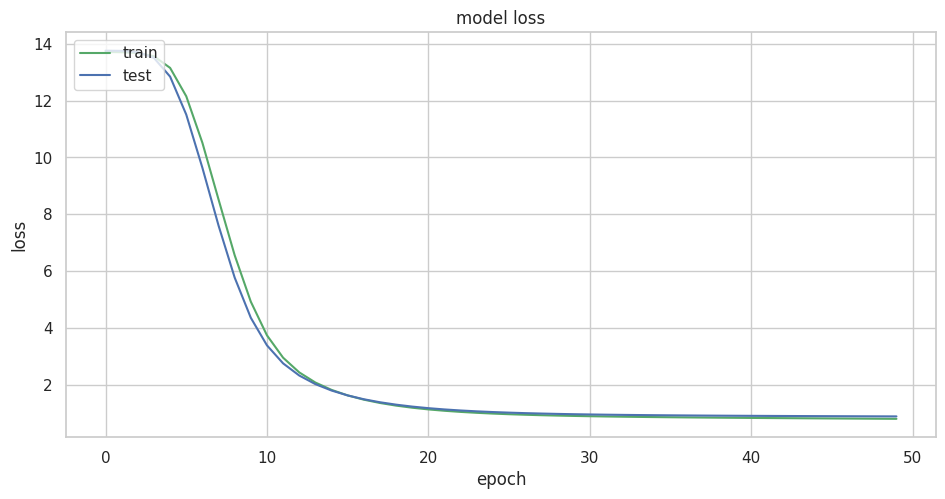

In [ ]:
rcParams['figure.figsize'] = 10, 5

plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Neural Network

### Creating Embeddings

In [ ]:
n_latent_factors=50
n_items=len(df['item_id'].unique())
n_users=len(df['user_id'].unique())

In [ ]:
user_input=Input(shape=(1,),name='user_input',dtype='int64')
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec=Flatten(name='FlattenUsers')(user_embedding)
user_vec=Dropout(0.40)(user_vec)

In [ ]:
item_input=Input(shape=(1,),name='item_input',dtype='int64')
item_embedding=Embedding(n_items,n_latent_factors,name='item_embedding')(item_input)
item_vec=Flatten(name='FlattenItems')(item_embedding)
item_vec=Dropout(0.40)(item_vec)

In [ ]:
sim=dot([user_vec,item_vec],name='Simalarity-Dot-Product',axes=1)

### Specifying Model Architecture

In [ ]:
nn_inp=Dense(96,activation='relu')(sim)
nn_inp=Dropout(0.4)(nn_inp)
nn_inp=BatchNormalization()(nn_inp)
nn_inp=Dense(1,activation='relu')(nn_inp)
nn_model =keras.models.Model([user_input, item_input],nn_inp)
nn_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │     47,150 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 1, 50)     │     84,100 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenUsers        │ (None, 50)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenItems        │ (None, 50)        │          0 │ item_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50)        │          0 │ FlattenUsers[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50)        │          0 │ FlattenItems[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Simalarity-Dot-Pro… │ (None, 1)         │          0 │ dropout[0][0],    │
│ (Dot)               │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 96)        │        192 │ Simalarity-Dot-P… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 96)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 96)        │        384 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         97 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 131,923 (515.32 KB)

 Trainable params: 131,731 (514.57 KB)

 Non-trainable params: 192 (768.00 B)

### Compiling Model

In [ ]:
nn_model.compile(optimizer=Adam(learning_rate=1e-3),loss='mse')

In [ ]:
batch_size=128
epochs=20

### Fitting on Training set & Validating on Validation Set

In [ ]:
History = nn_model.fit([train.user_id,train.item_id],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.user_id,valid.item_id],valid.rating),
                              verbose = 1)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.8642 - val_loss: 1.2741
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2563 - val_loss: 1.2737
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2712 - val_loss: 1.2731
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.2674 - val_loss: 1.2692
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1782 - val_loss: 1.0999
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9541 - val_loss: 0.9985
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8550 - val_loss: 0.9751
Epoch 8/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8108 - val_loss: 0.9493
Epoch 9/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7856 - val_loss: 0.9406
Epoch 10/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7660 - val_loss: 0.9278
Epoch 11/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7491 - val_loss: 0.9174
Epoch 12/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

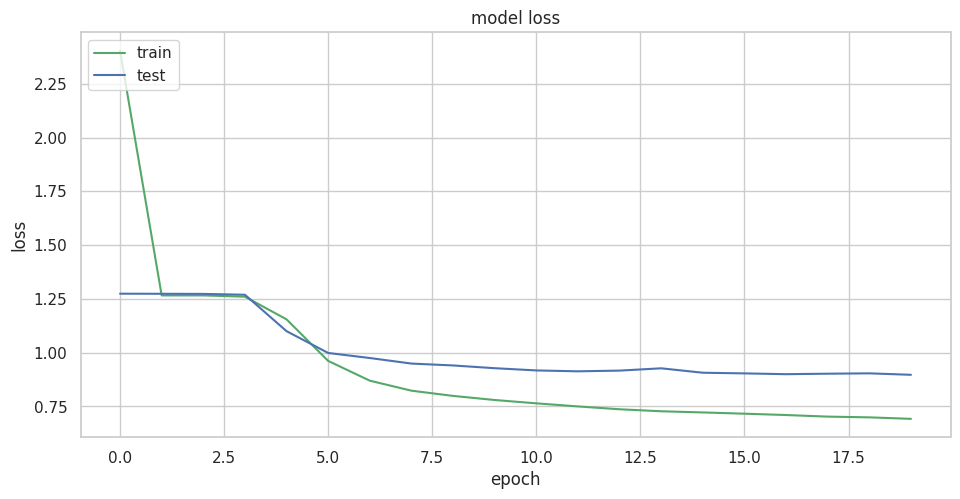

In [ ]:
rcParams['figure.figsize'] = 10, 5

plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

#slight overfitting

# LightGCN (BPR)

## Data Preparation

In [ ]:
df = df[df['rating']>=3]
print(len(df))

82520


In [ ]:
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


,rating
rating,
3,27145
4,34174
5,21201


In [ ]:
train, test = train_test_split(df.values, test_size=0.2, random_state = 16)
train = pd.DataFrame(train, columns = df.columns)
test = pd.DataFrame(test, columns = df.columns)

In [ ]:
print("Train Size  : ", len(train))
print("Test Size : ", len (test))

Train Size  :  66016
Test Size :  16504


### Label Encoding the User and Item IDs

In [ ]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train['user_id_idx'] = le_user.fit_transform(train['user_id'].values)
train['item_id_idx'] = le_item.fit_transform(train['item_id'].values)

In [ ]:
train_user_ids = train['user_id'].unique()
train_item_ids = train['item_id'].unique()

print(len(train_user_ids), len(train_item_ids))

test = test[(test['user_id'].isin(train_user_ids)) & (test['item_id'].isin(train_item_ids))]
print(len(test))

943 1546
16472


In [ ]:
test['user_id_idx'] = le_user.transform(test['user_id'].values)
test['item_id_idx'] = le_item.transform(test['item_id'].values)

In [ ]:
n_users = train['user_id_idx'].nunique()
n_items = train['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  943
Number of unique Items :  1546


In [ ]:
latent_dim = 64
n_layers = 3

In [ ]:
def convert_to_sparse_tensor(dok_mtrx):

    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)
    values = dok_mtrx_coo.data
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

## Modelling

### Metrics

In [ ]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):

    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight = item_Embed_wts)

    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
    R[train_data['user_id_idx'], train_data['item_id_idx']] = 1.0

    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense()

    R_tensor_dense = R_tensor_dense*(-np.inf)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)

    relevance_score = relevance_score+R_tensor_dense

    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])

    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index

    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]


    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    def get_hit_list(item_id_idx, top_rlvnt_itm):
        return [1 if x in set(item_id_idx) else 0 for x in top_rlvnt_itm ]

    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['item_id_idx'], x['top_rlvnt_itm']), axis = 1)

    def get_dcg_idcg(item_id_idx, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(item_id_idx),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg

    def get_cumsum(hit_list):
        return np.cumsum(hit_list)

    def get_map(item_id_idx, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)

    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['item_id_idx'], x['hit_list']), axis = 1)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['item_id_idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean()

### LightGCN Model

In [ ]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers, latent_dim):
        super(LightGCN, self).__init__()
        self.data = data
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        self.E0 = nn.Embedding(self.n_users + self.n_items, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self):
        R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32)
        R[self.data['user_id_idx'], self.data['item_id_idx']] = 1.0

        adj_mat = sp.dok_matrix(
                (self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32
            )
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: n_users, n_users :] = R
        adj_mat[n_users :, : n_users] = R.T
        adj_mat = adj_mat.todok()

        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)

        # Below Code is toconvert the dok_matrix to sparse tensor.

        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor

    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [n_users, n_items])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [n_users, n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed

    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0

In [ ]:
lightGCN = LightGCN(train, n_users, n_items, n_layers, latent_dim)

<ipython-input-22-2566522322>:48: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:644.)
  norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))


In [ ]:
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([2489, 64])


### BPR Loss

In [ ]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):

    reg_loss = (1/2)*(userEmb0.norm().pow(2) +
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)

    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))

    return loss, reg_loss

In [ ]:
def data_loader(data, batch_size, n_usr, n_itm):

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()

    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')

    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values

    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

In [ ]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.005)

In [ ]:
EPOCHS = 30
BATCH_SIZE = 1024
DECAY = 0.0001
K = 10

### Training Loop

In [ ]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = []

for epoch in tqdm(range(EPOCHS)):
    n_batch = int(len(train)/BATCH_SIZE)

    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []

    best_ndcg = -1

    train_start_time = time.time()
    lightGCN.train()
    for batch_idx in range(n_batch):

        optimizer.zero_grad()

        users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)

        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)

        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
        reg_loss = DECAY * reg_loss
        final_loss = mf_loss + reg_loss

        final_loss.backward()
        optimizer.step()

        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    lightGCN.eval()
    with torch.no_grad():

        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)


    if test_topK_ndcg > best_ndcg:
        best_ndcg = test_topK_ndcg

        torch.save(final_user_Embed, 'final_user_Embed.pt')
        torch.save(final_item_Embed, 'final_item_Embed.pt')
        torch.save(initial_user_Embed, 'initial_user_Embed.pt')
        torch.save(initial_item_Embed, 'initial_item_Embed.pt')


    eval_time = time.time() - train_end_time

    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
epoch_list = [(i+1) for i in range(EPOCHS)]

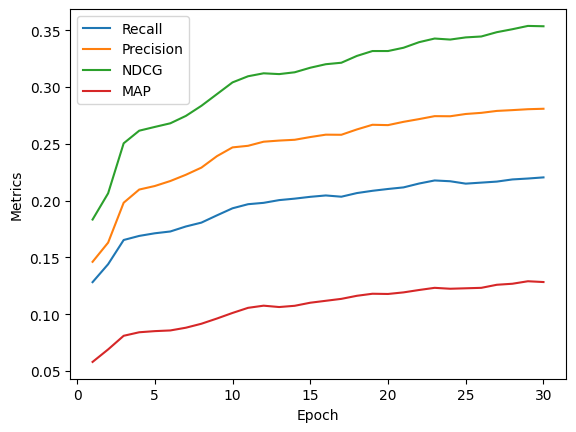

In [ ]:
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

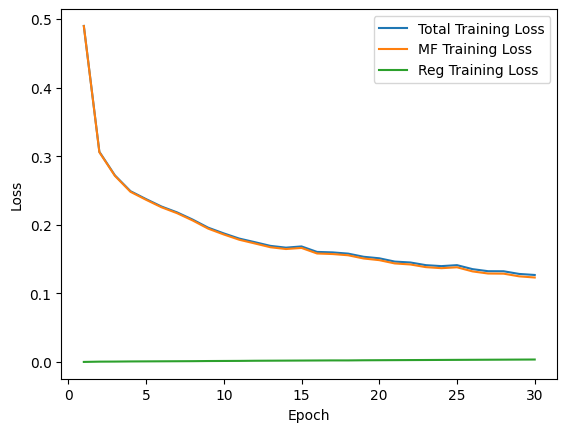

In [ ]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
print("Averge time taken to train an epoch -> ", round(np.mean(train_time_list),2), " seconds")
print("Averge time taken to eval an epoch -> ", round(np.mean(eval_time_list),2), " seconds")

Averge time taken to train an epoch ->  4.59  seconds
Averge time taken to eval an epoch ->  0.35  seconds


In [ ]:
print("Last Epoch's Test Data Recall -> ", recall_list[-1])
print("Last Epoch's Test Data Precision -> ", precision_list[-1])
print("Last Epoch's Test Data NDCG -> ", ndcg_list[-1])
print("Last Epoch's Test Data MAP -> ", map_list[-1])

print("Last Epoch's Train Data Loss -> ", loss_list_epoch[-1])

Last Epoch's Test Data Recall ->  0.2204
Last Epoch's Test Data Precision ->  0.2808
Last Epoch's Test Data NDCG ->  0.3534
Last Epoch's Test Data MAP ->  0.1283
Last Epoch's Train Data Loss ->  0.1269
